In [6]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean
import scipy

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [7]:
#import dataset
df1 = pd.read_csv('./final_data/df_pm_o3_county_nuclear_geo_avg.csv', index_col = 0)

In [8]:
#import dataset
df2 = pd.read_csv('./final_data/df_pm_o3_county_nuclear_geo_avg_nocoal.csv', index_col = 0)

In [9]:
df = df1.merge(df2, on = ['COUNTYNS','County_State','geometry_county','nuclear_adjacent', 'coal_containing','CountyName','StateName'], suffixes = ("_nonuc", "_nonuc_coal"))

In [10]:
df['County_State'] = df['County_State'].str.lower()

Census data through: https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html Annual County resident Population Estimates by Age, Sex, Race and Hispanic Origin: April 1, 2010- July 1, 2019 (CC-EST2019-ALLDATA)

In [11]:
census_df = pd.read_csv('final_data/cc-est2019-alldata.csv',engine='python',encoding='latin1')

In [12]:
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' Parish', '')
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' County', '')
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' city', '')

In [13]:
census_df['CTYNAME'] = census_df['CTYNAME'].str.lower()
census_df['STNAME'] = census_df['STNAME'].str.lower()
census_df['County_State'] = census_df['CTYNAME'] + ', ' + census_df['STNAME']

In [14]:
census_df = census_df[census_df.STNAME.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]
census_df = census_df.loc[census_df['YEAR'] == 9] #select for the 2016 population estimate (see https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf for detail)

In [15]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]

In [16]:
#find dif between two lists:
for cs in list(set(census_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


In [17]:
combined_df = census_df.groupby('County_State').sum().merge(poll_df.groupby('County_State').mean(), left_index = True, right_index=True)
combined_df = combined_df.drop(columns = {'AGEGRP','STATE','COUNTY','YEAR','SUMLEV','COUNTYNS'})

In [18]:
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(poll_df.groupby('County_State').first()['geometry_county'])

In [19]:
#create geo dataframe
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')
combined_df = geo_df.copy()

In [20]:
#convet to ppb
combined_df['O3_nonuc']*=1e9
combined_df['O3_nonuc_coal']*=1e9

## Average Exposure by Race and Ethnicity

In [21]:
def grouped_weighted_avg(values, weights):
    return (values * weights).sum() / weights.sum()

Although we have more data specificity in the census, we'll just be looking at what we can compare to the WONDER data

In [22]:
combined_df['American Indian or Alaska Native'] = combined_df['IA_MALE']+combined_df['IA_FEMALE']
combined_df['White'] = combined_df['WA_MALE']+combined_df['WA_FEMALE']
combined_df['Black or African American'] = combined_df['BA_MALE']+combined_df['BA_FEMALE']
combined_df['Asian or Pacific Islander'] = combined_df['NA_MALE']+combined_df['NA_FEMALE'] + combined_df['AA_MALE']+combined_df['AA_FEMALE'] 
combined_df['Hispanic or Latino'] = combined_df['H_MALE']+combined_df['H_FEMALE']

In [23]:
for poll in ['PM25_nonuc','PM25_nonuc_coal','O3_nonuc','O3_nonuc_coal']:
    print('\n', poll, '\n')
    for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
        
        print(re, grouped_weighted_avg(combined_df[poll], combined_df[re]))


 PM25_nonuc 

American Indian or Alaska Native 0.10653918377233584
Asian or Pacific Islander 0.12450537181762347
Black or African American 0.20089114520423726
Hispanic or Latino 0.09983189674237407
White 0.17174596260130212

 PM25_nonuc_coal 

American Indian or Alaska Native 0.1254960135647942
Asian or Pacific Islander 0.14712624958912804
Black or African American 0.26547860249178384
Hispanic or Latino 0.08562719451539301
White 0.18314265986676304

 O3_nonuc 

American Indian or Alaska Native 0.2428919077170949
Asian or Pacific Islander 0.2386353073153416
Black or African American 0.4834076455295037
Hispanic or Latino 0.1885408841603031
White 0.35966915086465095

 O3_nonuc_coal 

American Indian or Alaska Native 0.4136703921695204
Asian or Pacific Islander 0.2653304478802516
Black or African American 0.83015259929917
Hispanic or Latino 0.24176553300949202
White 0.49067143741190716


## Exposure by Nuclear Adjacent or not

In [32]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'PM25_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'PM25_{run}'].groupby('County_State').mean().mean())
    print('O3')
    print('Near', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'O3_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'O3_{run}'].groupby('County_State').mean().mean())

PM25
Near nonuc
0.24304054408935982
Not nonuc
0.17685707192572656
O3
Near nonuc
0.5760561433803049
Not nonuc
0.41881929309624366
PM25
Near nonuc_coal
0.3876467148139648
Not nonuc_coal
0.11447732278451961
O3
Near nonuc_coal
1.2700784940605638
Not nonuc_coal
0.5932563997659832


## Exposure by coal containing or not

In [33]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(combined_df.loc[combined_df['coal_containing'] == 1][f'PM25_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(combined_df.loc[combined_df['coal_containing'] == 0][f'PM25_{run}'].groupby('County_State').mean().mean())
    print('O3')
    print('Near', run)
    print(combined_df.loc[combined_df['coal_containing'] == 1][f'O3_{run}'].groupby('County_State').mean().mean())
    print('Not', run)
    print(combined_df.loc[combined_df['coal_containing'] == 0][f'O3_{run}'].groupby('County_State').mean().mean())

PM25
Near nonuc
0.2393765338879932
Not nonuc
0.1907366693929115
O3
Near nonuc
0.46783697531198576
Not nonuc
0.46299209903940214
PM25
Near nonuc_coal
0.16859804628722552
Not nonuc_coal
0.19473932511091205
O3
Near nonuc_coal
0.7179043888444544
Not nonuc_coal
0.7927839572155517


## Maps of Different County Exposure by State

In [19]:
counties = geopandas.read_file('data/cb_2018_us_county_500k.shx')
counties = counties.rename(columns = {'NAME':'CountyName'})

states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states = states.rename(columns = {'NAME':'StateName'})

states['StateName'] = states['StateName'].str.lower()
counties['STATEFP'] = counties['STATEFP'].astype("string")

In [20]:
combined_df['State'] = census_df.groupby('County_State').first()['STNAME']

/tmp/ipykernel_2428738/696072841.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2428738/696072841.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


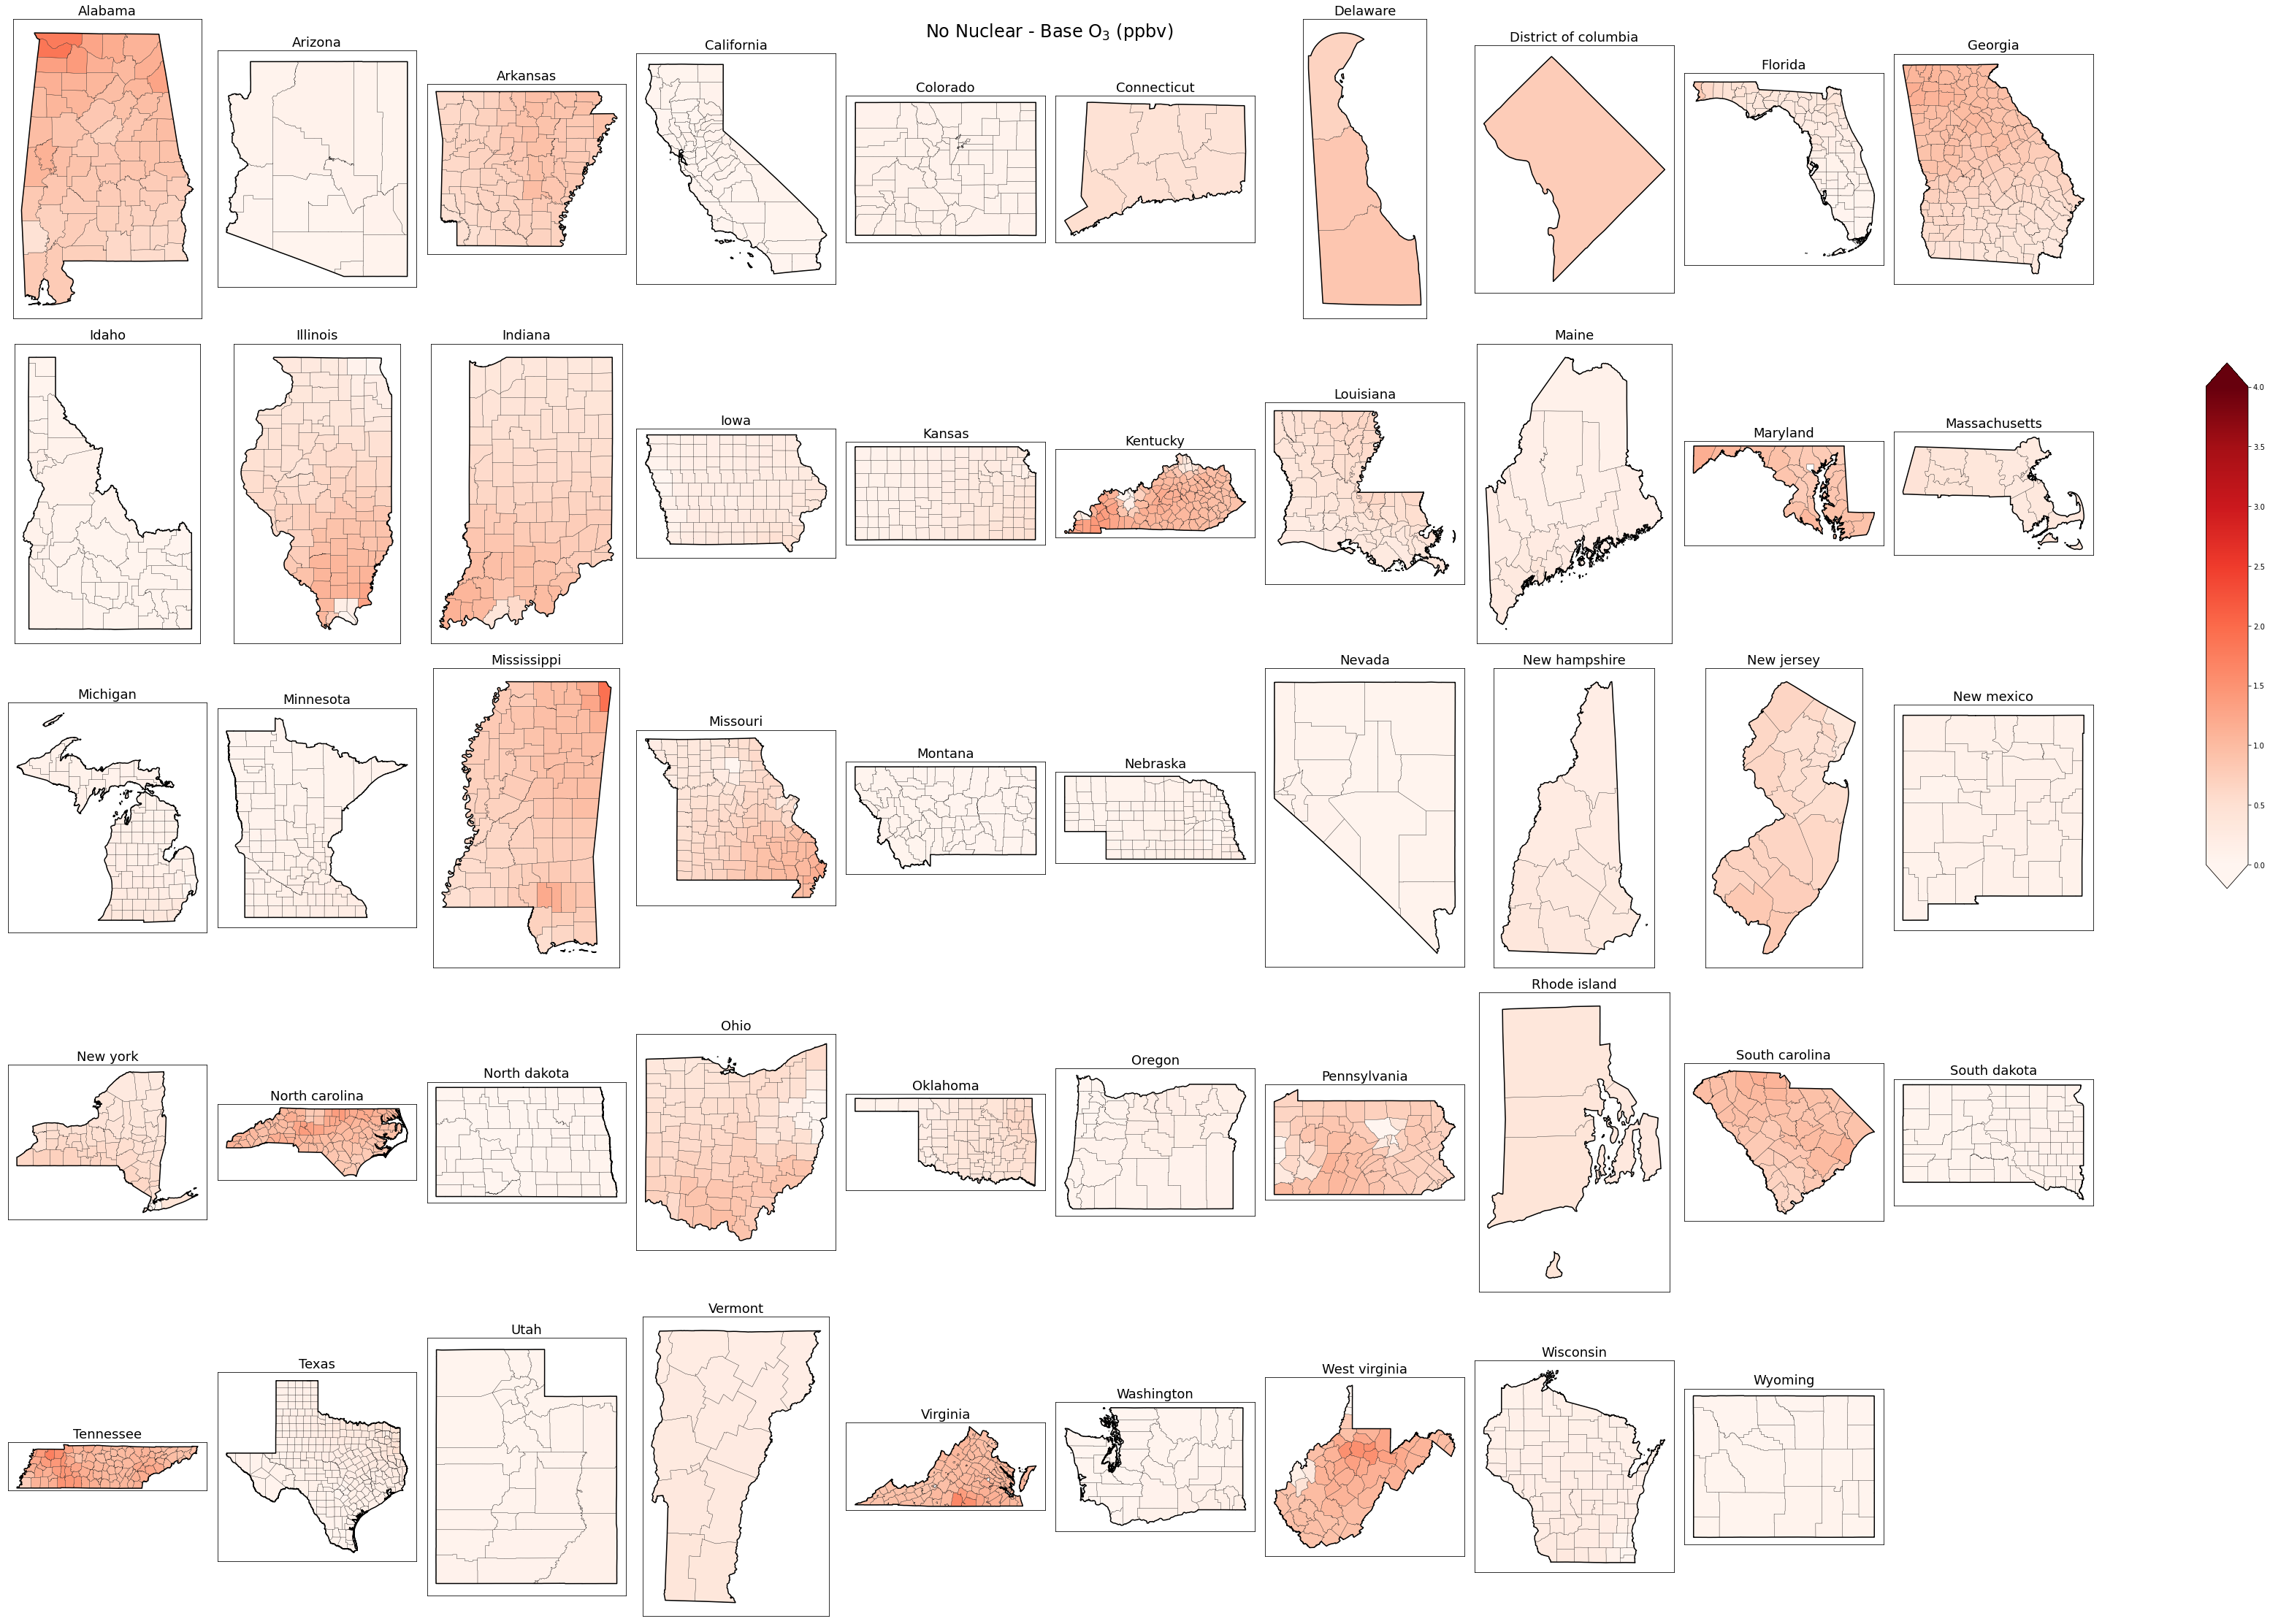

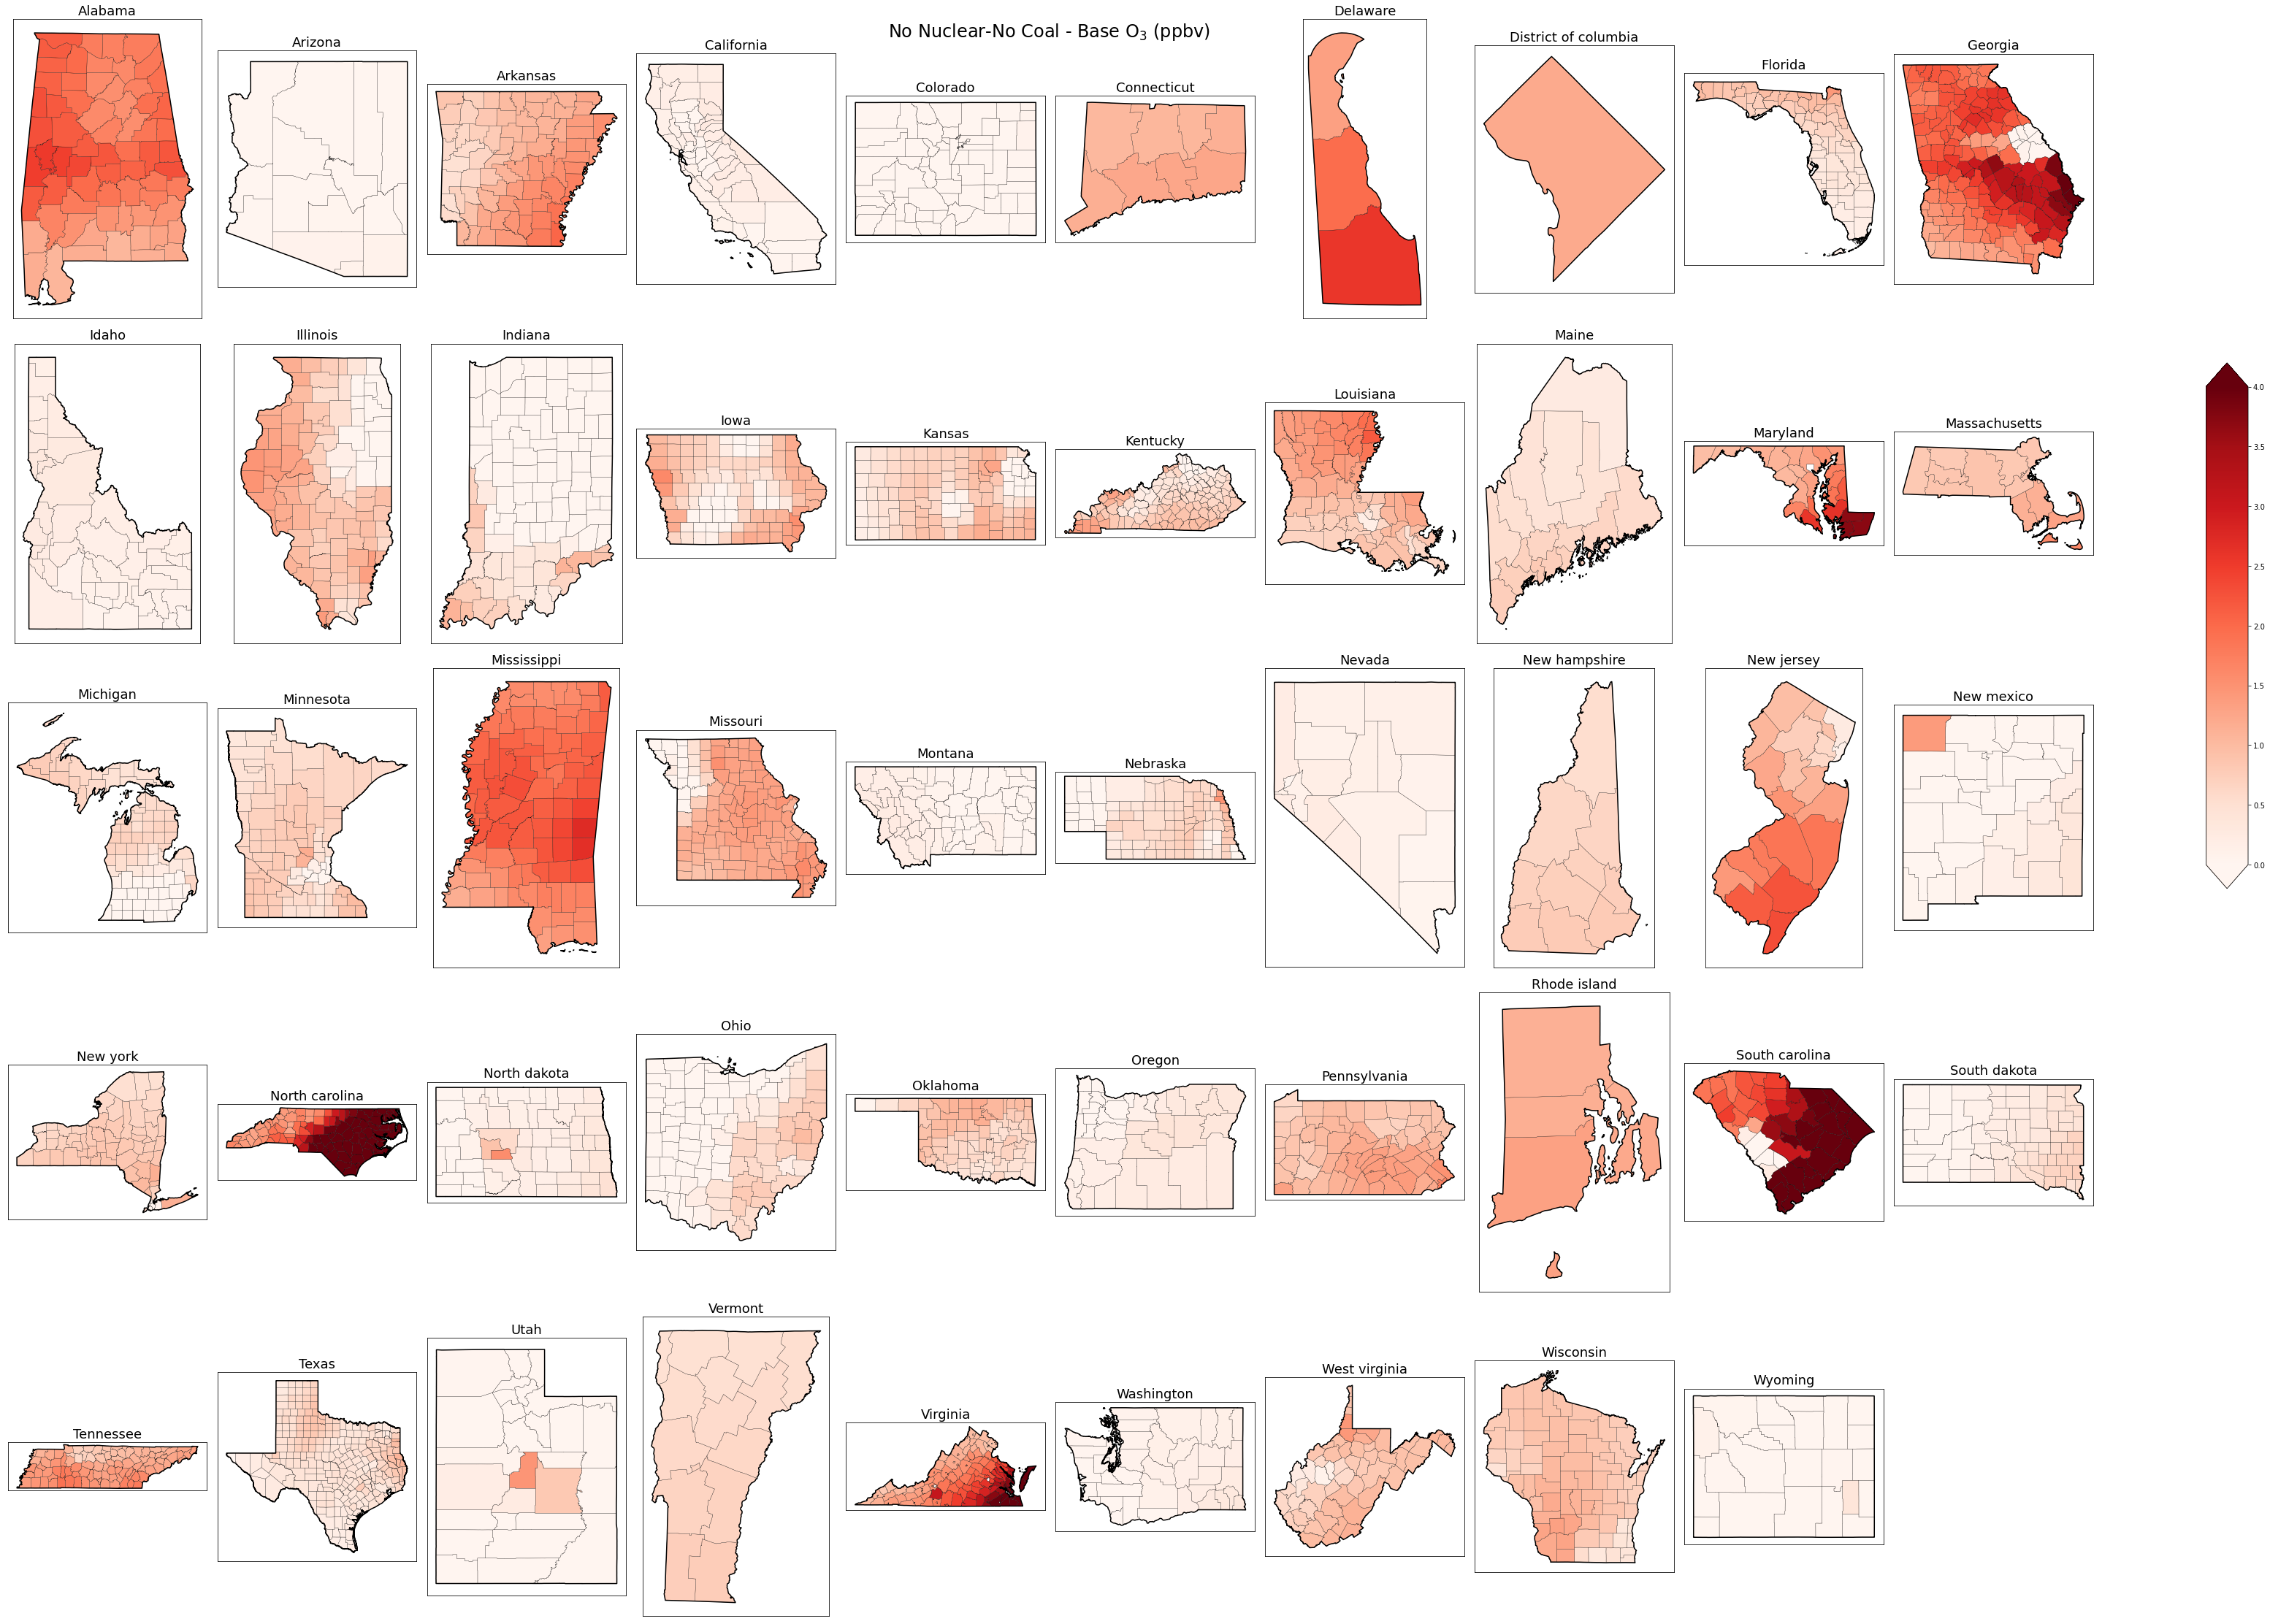

In [21]:
vmin = 0
vmax = 4
for idx, run in enumerate(['nonuc','nonuc_coal']):
    fig = plt.figure(figsize=[40,50])
    for idx_s, state in enumerate(np.unique(combined_df['State'])):
        ###OZONE###
        ax = fig.add_subplot(8,10,idx_s+1)
        q = combined_df.loc[combined_df['State'] == state].plot(ax = ax, column = f'O3_{run}', legend=False, 
                                                 vmin = vmin, vmax = vmax, 
                                                 cmap = 'Reds')
        statefp = states.loc[states['StateName'] == state]['STATEFP'].values[0]
        counties.loc[counties['STATEFP'] == statefp].boundary.plot(ax = ax, color = 'k', linewidth = .2)
        states.loc[states['StateName'] == state].boundary.plot(ax = ax, color = 'k',)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(state.capitalize(), fontsize = 18)
    # Add single colorbar
    cax = fig.add_axes([1.05, 0.65, 0.02, 0.2])
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, extend = 'both')
    
    if run == 'nonuc':
        plt.suptitle(r'No Nuclear - Base O$_3$ (ppbv)', fontsize = 24)
    if run == 'nonuc_coal':
        plt.suptitle(r'No Nuclear-No Coal - Base O$_3$ (ppbv)', fontsize = 24)  
    plt.tight_layout()
    plt.savefig(f'Figures/{run}_ozone_state_map.png', dpi = 150, bbox_inches = 'tight')


/tmp/ipykernel_2428738/1277785920.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2428738/1277785920.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


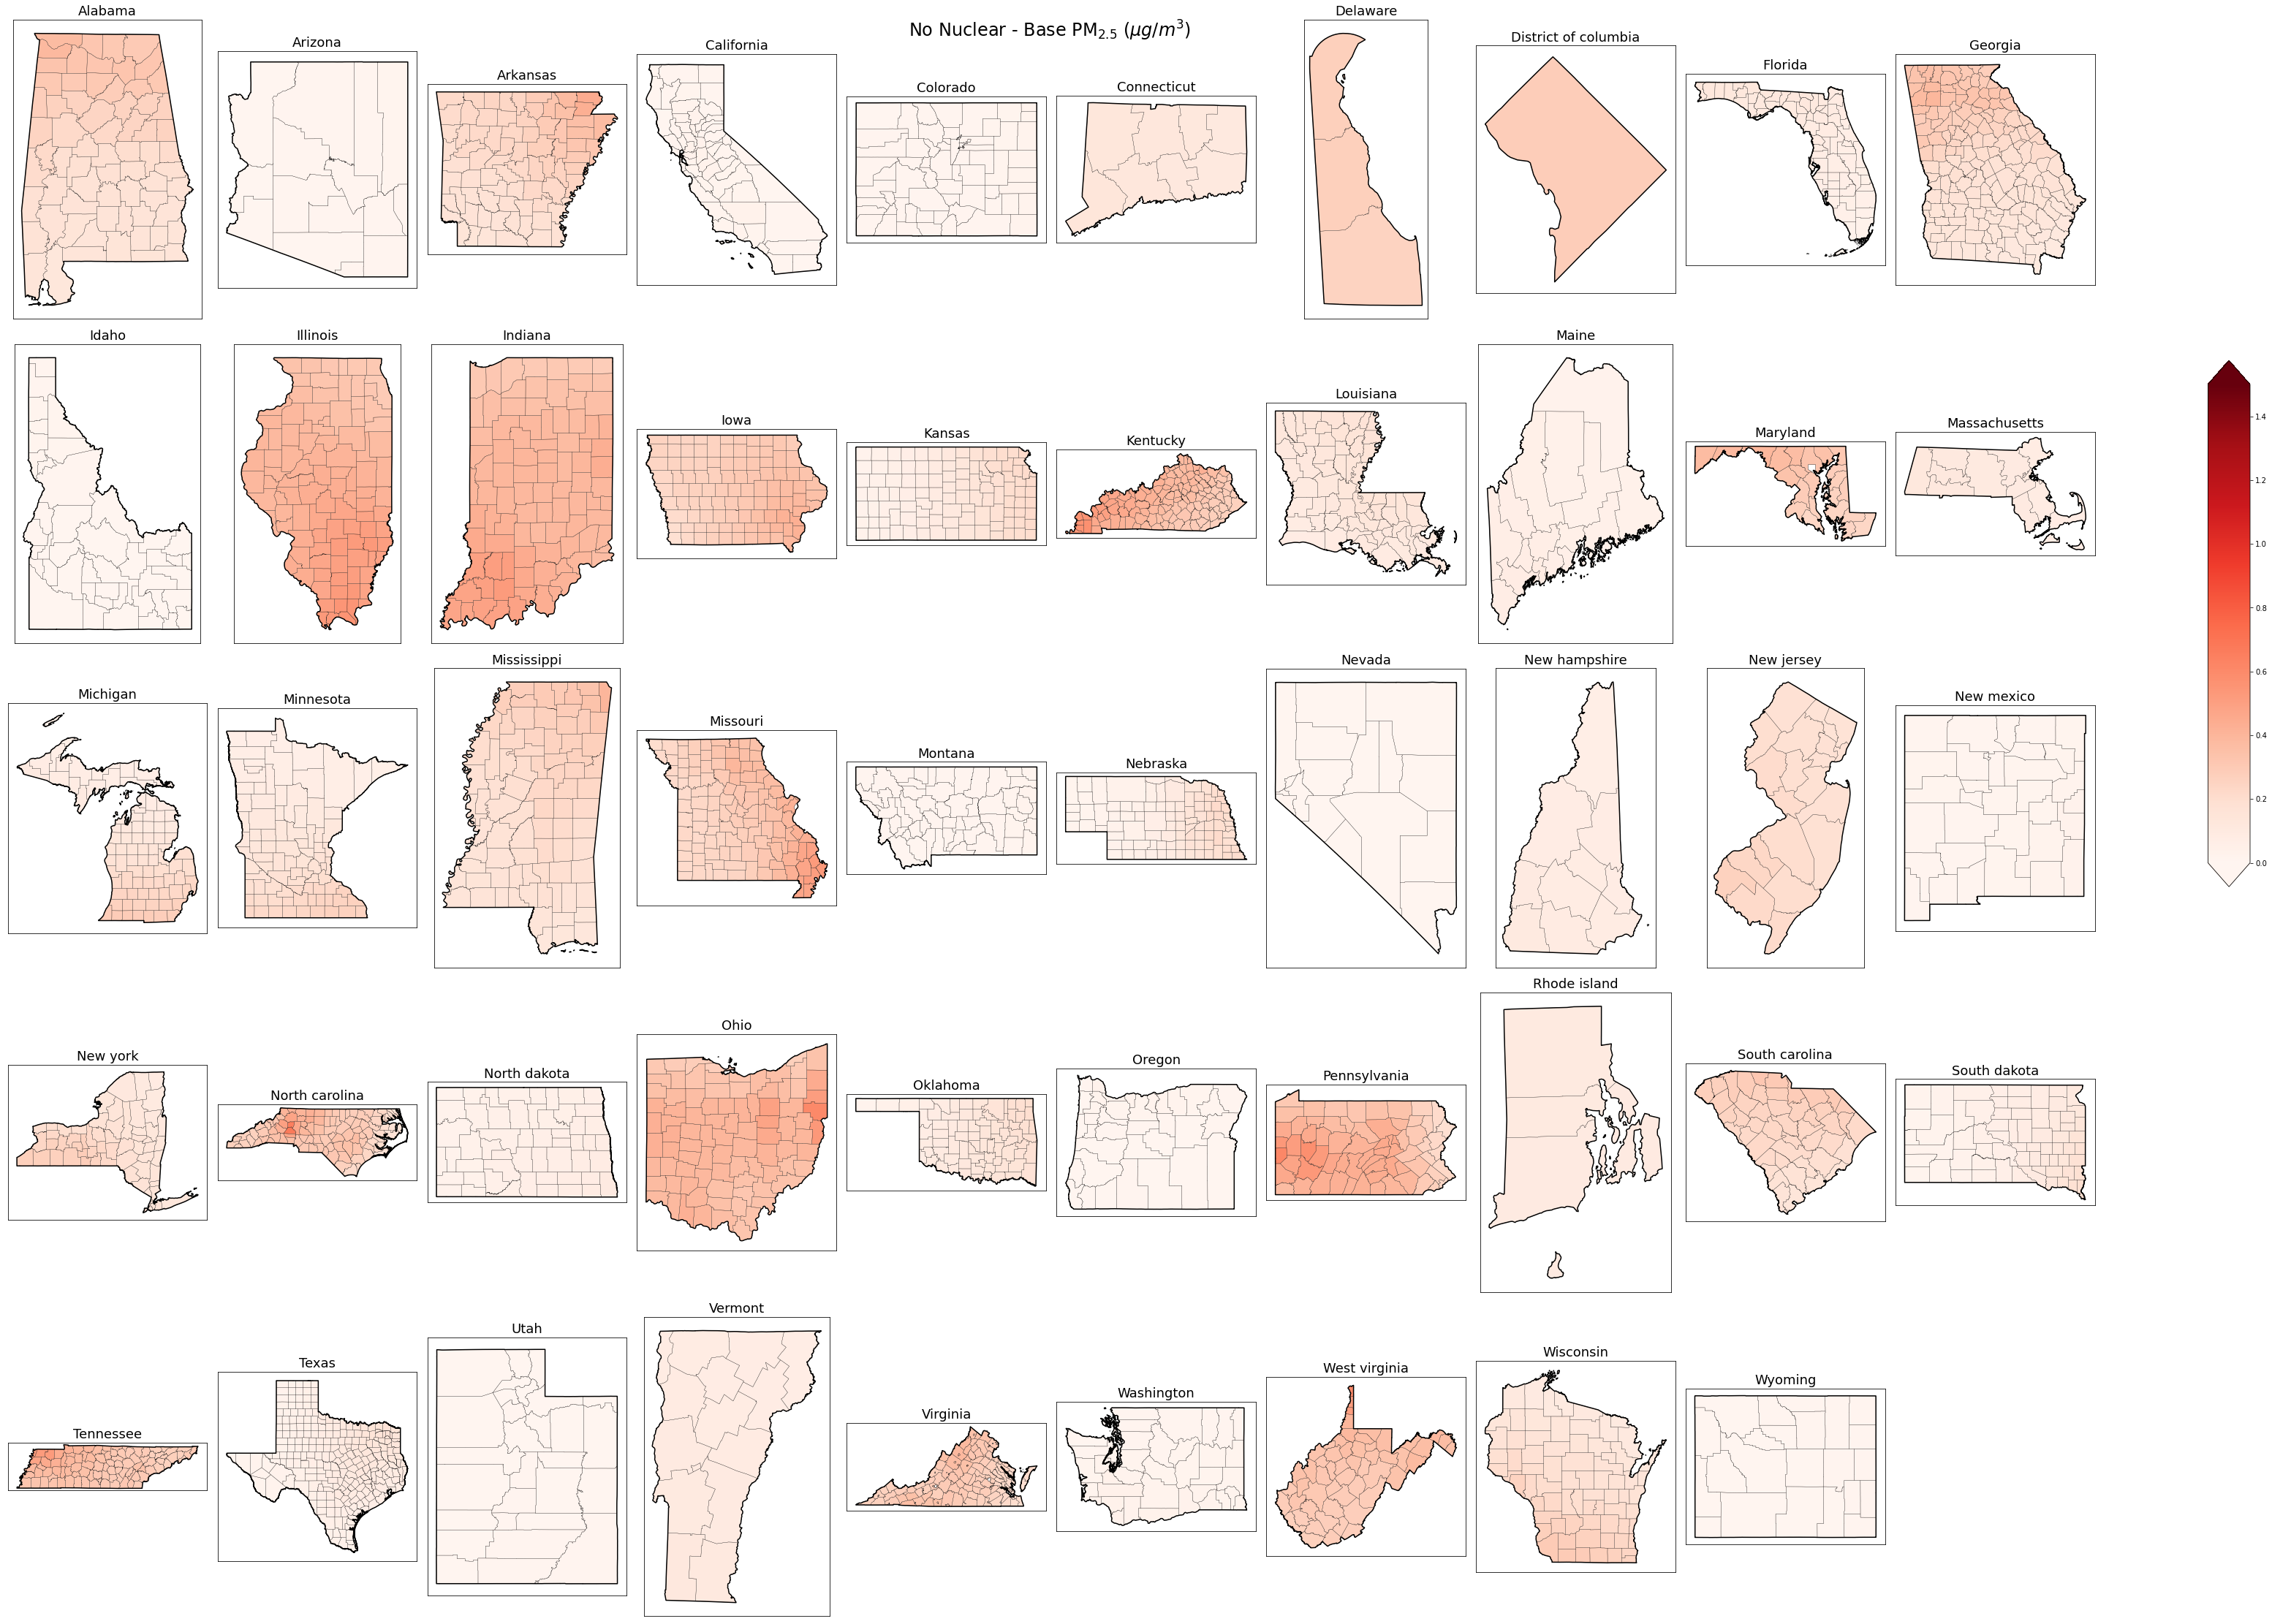

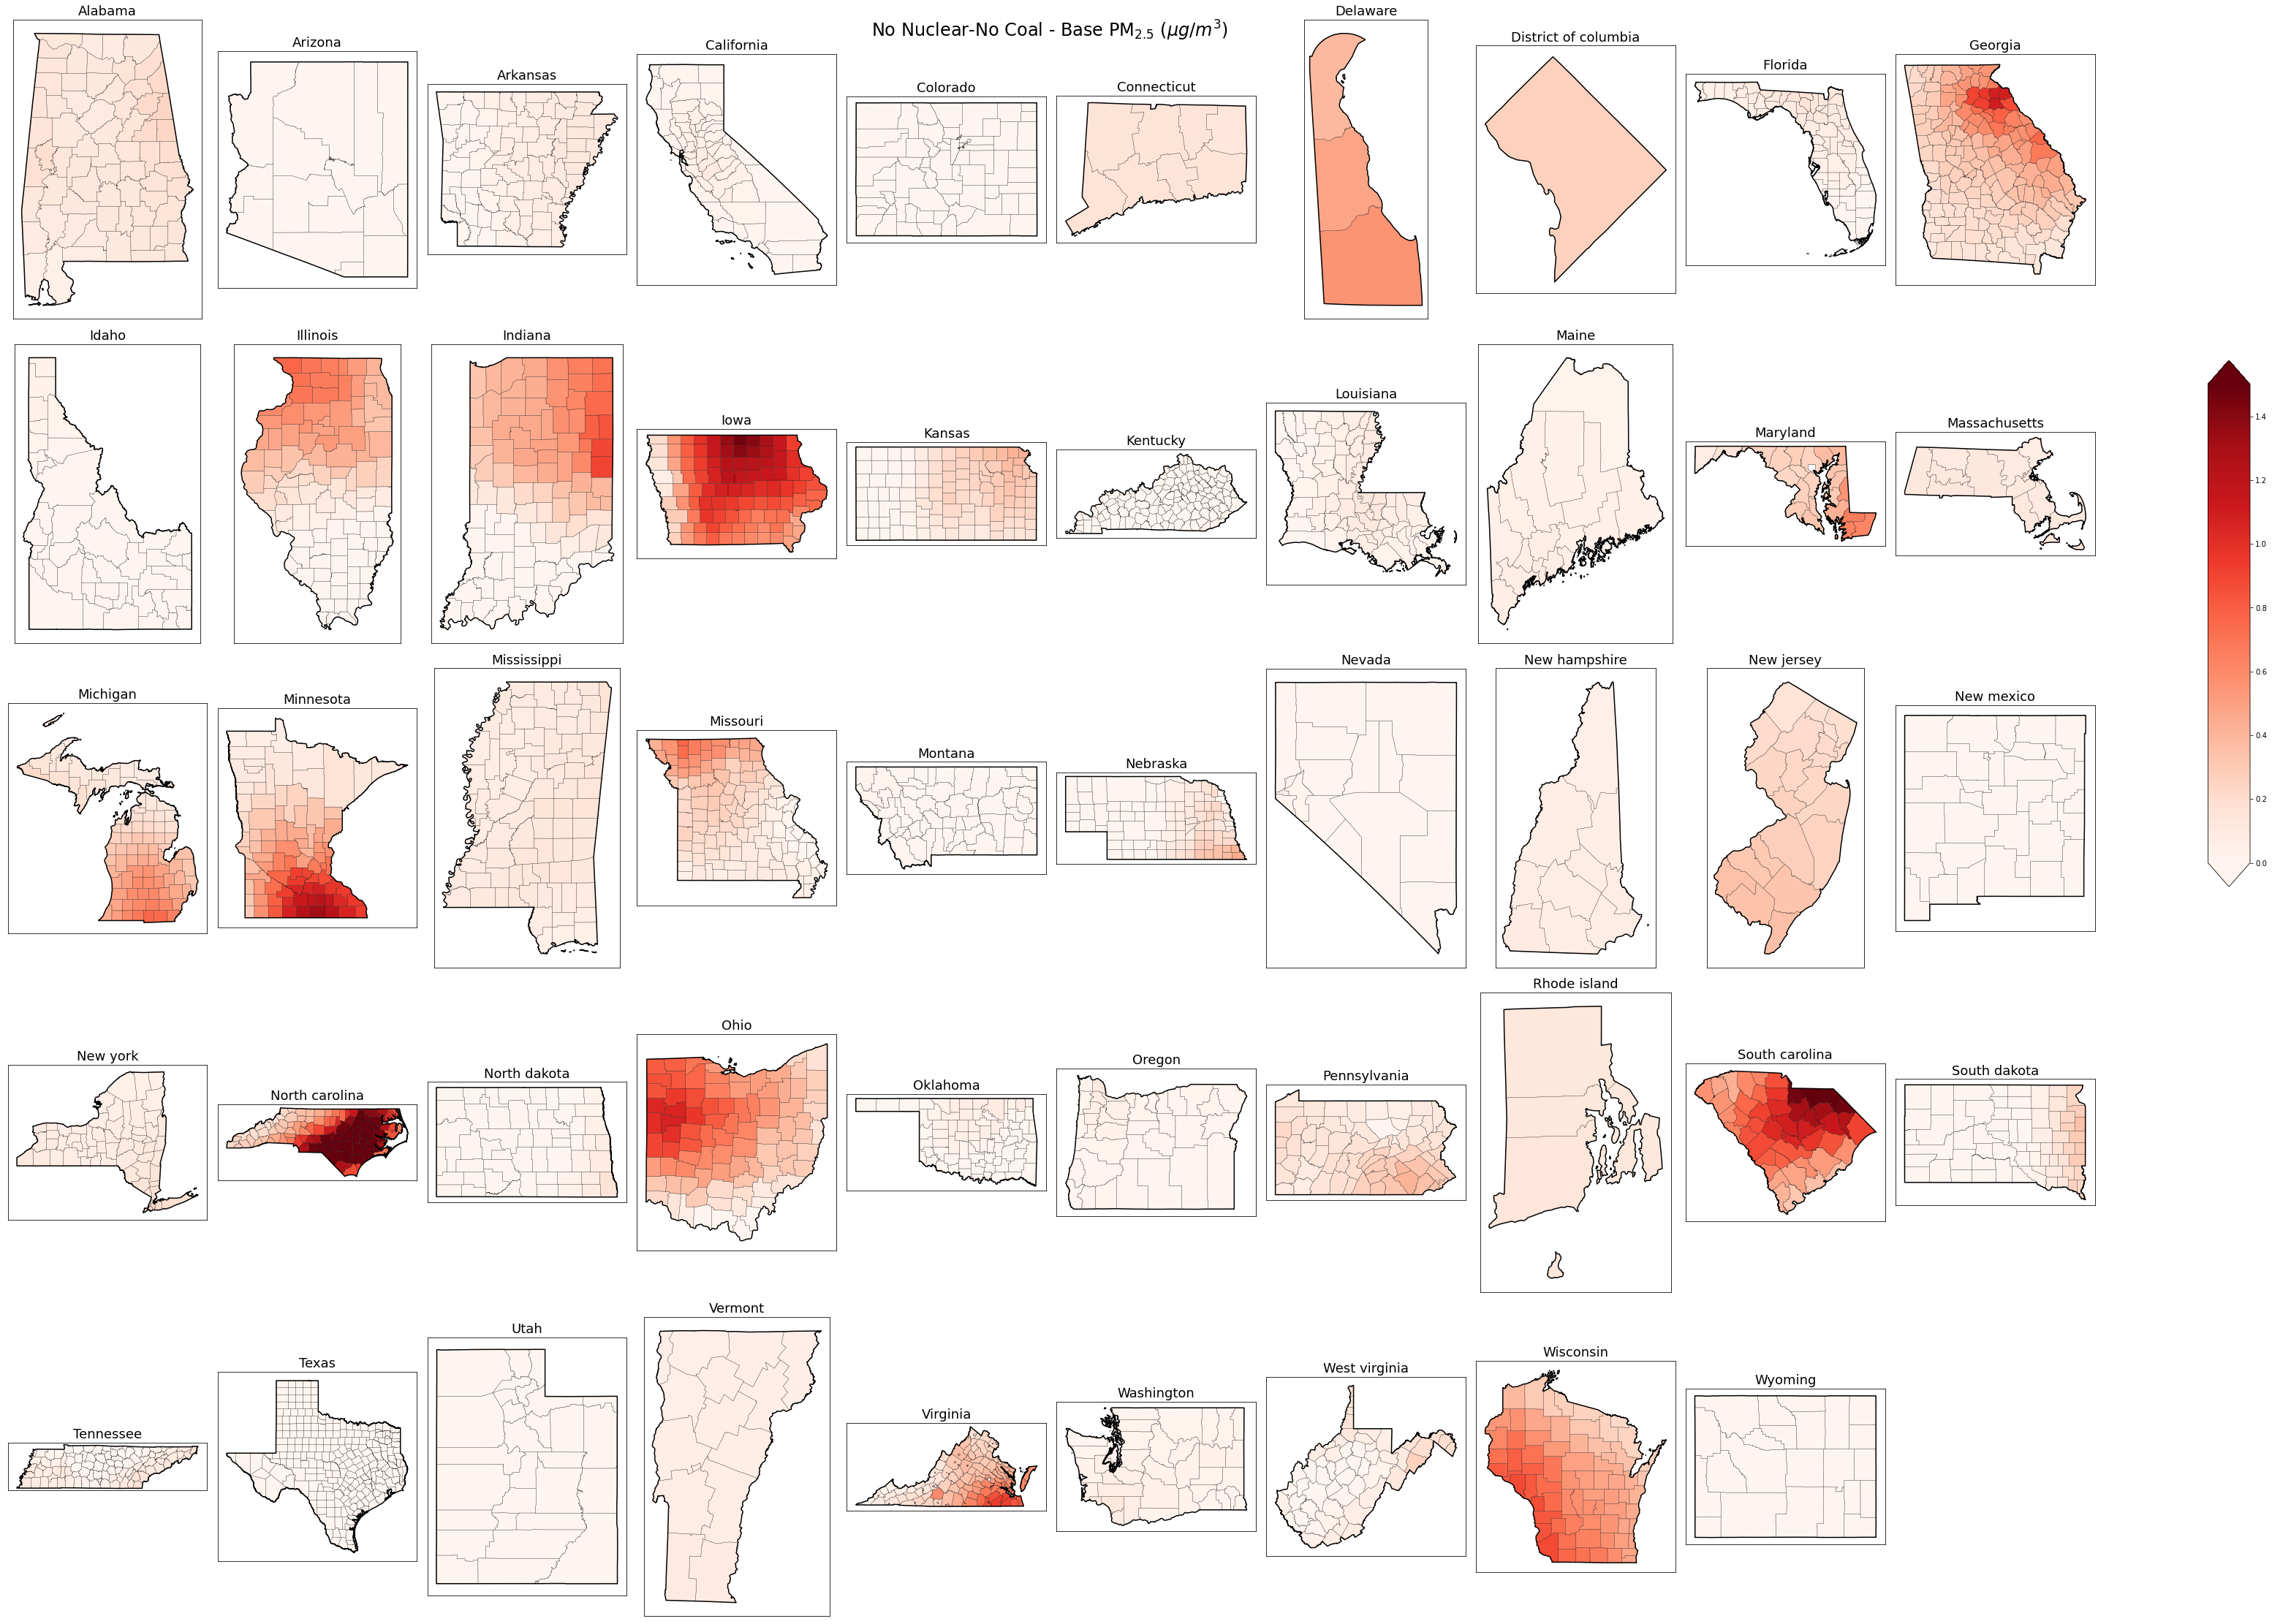

In [22]:
vmin = 0
vmax = 1.5
for idx, run in enumerate(['nonuc','nonuc_coal']):
    fig = plt.figure(figsize=[40,50])
    for idx_s, state in enumerate(np.unique(combined_df['State'])):
        ###PM###
        ax = fig.add_subplot(8,10,idx_s+1)
        q = combined_df.loc[combined_df['State'] == state].plot(ax = ax, column = f'PM25_{run}', legend=False, 
                                                 vmin = vmin, vmax = vmax,  
                                                 cmap = 'Reds')
        statefp = states.loc[states['StateName'] == state]['STATEFP'].values[0]
        counties.loc[counties['STATEFP'] == statefp].boundary.plot(ax = ax, color = 'k', linewidth = .2)
        states.loc[states['StateName'] == state].boundary.plot(ax = ax, color = 'k',)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(state.capitalize(), fontsize = 18)
        
    # Add single colorbar
    cax = fig.add_axes([1.05, 0.65, 0.02, 0.2])
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, extend = 'both')

    if run == 'nonuc':
        plt.suptitle(r'No Nuclear - Base PM$_{2.5}$ ($\mu g/m^3$)', fontsize = 24)
    if run == 'nonuc_coal':
        plt.suptitle(r'No Nuclear-No Coal - Base PM$_{2.5}$ ($\mu g/m^3$)', fontsize = 24)  
    plt.tight_layout()
    plt.savefig(f'Figures/{run}_pm_state_map.png', dpi = 150, bbox_inches = 'tight')
